Theta_star_0:  [ 2.79429277  1.73116594  0.75485763 ...  1.66521198 -0.24037864
 -1.28251932]
w_star_0:  [-2.01732752e-08  1.02574477e-07 -3.03581145e-08 ...  3.12286701e-09
 -7.92038920e-07  3.86279571e+00]
Screen Ratio for k=1: 0.0
Screen Ratio for k=2: 0.0
Screen Ratio for k=3: 0.0
Screen Ratio for k=4: 0.0
Screen Ratio for k=5: 0.0


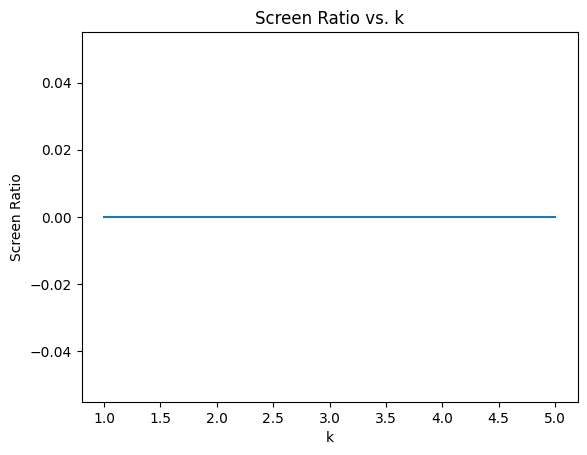

In [60]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open('restaurant_reviews.pkl', 'rb') as f:
    data = pickle.load(f)

X, y, name = data
X = np.array(X)
n, m = X.shape

lambda_0 = 2.5
r = 0.93
lambdas = [lambda_0 * r**k for k in range(6)]
gamma = 1  # assume strong convexity parameter is 1

# solve for w*(0) and theta*(0)
w = cp.Variable(m)

objective = 0.5 * cp.sum_squares(X @ w - y) + lambdas[0] * cp.norm(w, 1)
constraints = [w >= 0]

problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

w_star_0 = w.value
theta_star_0 = X @ w_star_0 - y

print("Theta_star_0: ", theta_star_0)
print("w_star_0: ", w_star_0)

def get_G(theta, y): 
    return 0.5*(cp.square(cp.norm(theta))) + theta.T @ y

def get_F(w, x, y): 
    return 0.5 * cp.sum_squares(X @ w - y)

# Apply feature elimination rule
screen_ratios = []

for k in range(1, 6):
    lambda_k = lambdas[k]
    theta_tilde = (lambda_k / lambda_0) * theta_star_0

    """
    If I were to implement part b: 
    
    theta_tilde = (lambda_k / lambdas[k-1]) * theta_star_0
    w_tilde = w_star_0 / (lambda_k / lambdas[k-1])

    we are performing feature reduction so I'd expect the screen ratio to decrease nearly uniformly at each k for part (i) 

    for part ii I'd expect the monotonic decreasing fashion of k to stay the same but with higher screen ratios like the ratios at each
    k are nearly reaching the same point. 

    at each step more features are being eliminated as the optimization problem progresses 

    the theta_tilde and w_tilde are normalized factors less than one so as k increases they are decreasing. As more features are eliminated,
    the screening ration decreasines because the proportion of remaining features decreases in total. 

    """

    G = get_G(theta_tilde,y) 
    F = get_F(w_star_0,x,y) 

    # Compute elimination condition
    elimination_condition = (cp.norm(X.T) * (cp.sqrt(2*(G + F)))) <= cp.norm(lambda_k + X.T @ theta_tilde, axis=0)
    
    # Count features to be eliminated
    features_to_eliminate = np.sum(elimination_condition.value == True)
    screen_ratio = features_to_eliminate / m
    screen_ratios.append(screen_ratio)

    print(f"Screen Ratio for k={k}: {screen_ratio}")

# Plot screen ratio
plt.plot(range(1, 6), screen_ratios)
plt.xlabel("k")
plt.ylabel("Screen Ratio")
plt.title("Screen Ratio vs. k")
plt.show()
